In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
# Phishing Email Detection Project

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 3. Feature extraction function
def extract_features(X_train, X_val, method, max_features=1000):
    if method == "tfidf":
        vec = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5, ngram_range=(1, 2))
    else:
        vec =  CountVectorizer(stop_words='english', max_df=0.95, min_df=5, ngram_range=(1, 2))
    X_train_vec = vec.fit_transform(X_train)
    X_val_vec = vec.transform(X_val)
    return X_train_vec, X_val_vec, vec

# 4. K-fold validation

def run_kfold(X, y, method, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    accs, f1s, precs, recalls = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        X_train_vec, X_val_vec, vec = extract_features(X_train, X_val, method)

        model = LogisticRegression(max_iter=500, class_weight='balanced')
        model.fit(X_train_vec, y_train)
        preds = model.predict(X_val_vec)

        accs.append(accuracy_score(y_val, preds))
        f1s.append(f1_score(y_val, preds))
        precs.append(precision_score(y_val, preds))
        recalls.append(recall_score(y_val, preds))

        print(f"Fold {fold}: Accuracy={accs[-1]:.4f}, F1={f1s[-1]:.4f}, Precision={precs[-1]:.4f}, Recall={recalls[-1]:.4f}")

    print(f"\n{method.upper()} Avg Accuracy over {k} folds: {np.mean(accs):.4f}")
    print(f"{method.upper()} Avg F1-score: {np.mean(f1s):.4f}")
    print(f"{method.upper()} Avg Precision: {np.mean(precs):.4f}")
    print(f"{method.upper()} Avg Recall: {np.mean(recalls):.4f}")

    # 🎨
    folds = list(range(1, k + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(folds, accs, label='Accuracy', marker='o')
    plt.plot(folds, f1s, label='F1 Score', marker='s')
    plt.plot(folds, precs, label='Precision', marker='^')
    plt.plot(folds, recalls, label='Recall', marker='d')
    plt.title(f"{method.upper()} Performance Across {k} Folds")
    plt.xlabel("Fold")
    plt.ylabel("Score")
    all_scores = accs + f1s + precs + recalls
    y_min = max(min(all_scores) - 0.01, 0.90)
    y_max = min(max(all_scores) + 0.01, 1.0)
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_and_test(extract_method):
    # 1. Load and clean the dataset
    # Replace this path with your actual file
    df = pd.read_csv("D:\GITHUB\Summer-2025-ECE-597-Group11\data\kaggle\CEAS_08.csv")

    # Clean text column
    df['clean_text'] = df['body'].fillna('').str.lower()
    df['clean_text'] = df['clean_text'].str.replace(r'[^a-z\s]', '', regex=True)

    # Convert labels to numeric: phishing=1, legitimate=0
    df['Label'] = df['label']

    # 2. Train/test split
    X = df['clean_text']
    y = df['Label']

    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    # Adjust training set to have approx. 10:1 ratio (legitimate : phishing)
    train_df = pd.DataFrame({'text': X_trainval, 'label': y_trainval})
    phishing_df = train_df[train_df['label'] == 1]
    legitimate_df = train_df[train_df['label'] == 0]
    desired_legit_count = min(len(legitimate_df), 10 * len(phishing_df))
    legitimate_sampled = legitimate_df.sample(n=desired_legit_count, random_state=42)
    balanced_train_df = pd.concat([phishing_df, legitimate_sampled])
    X_trainval = balanced_train_df['text']
    y_trainval = balanced_train_df['label']
    run_kfold(X_trainval, y_trainval, method=extract_method)

    # Run k-fold validation for both methods
    # run_kfold(X_trainval, y_trainval, method="tfidf")
    # run_kfold(X_trainval, y_trainval, method="bow")

    # 5. Final model evaluation on test set
    X_train_vec, X_test_vec, vec = extract_features(X_trainval, X_test, method=extract_method)
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train_vec, y_trainval)
    y_pred = model.predict(X_test_vec)

    print(f"\nFinal Test Accuracy using {extract_method}:{accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred,digits=6))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {extract_method} Test")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return model,vec


<>:74: SyntaxWarning: invalid escape sequence '\G'
<>:74: SyntaxWarning: invalid escape sequence '\G'
C:\Users\yck\AppData\Local\Temp\ipykernel_42700\650299349.py:74: SyntaxWarning: invalid escape sequence '\G'
  df = pd.read_csv("D:\GITHUB\Summer-2025-ECE-597-Group11\data\kaggle\CEAS_08.csv")


Fold 1: Accuracy=0.9940, F1=0.9947, Precision=0.9947, Recall=0.9947
Fold 2: Accuracy=0.9905, F1=0.9915, Precision=0.9909, Recall=0.9922
Fold 3: Accuracy=0.9945, F1=0.9950, Precision=0.9951, Recall=0.9948
Fold 4: Accuracy=0.9945, F1=0.9951, Precision=0.9967, Recall=0.9934
Fold 5: Accuracy=0.9938, F1=0.9944, Precision=0.9929, Recall=0.9959

TFIDF Avg Accuracy over 5 folds: 0.9934
TFIDF Avg F1-score: 0.9941
TFIDF Avg Precision: 0.9941
TFIDF Avg Recall: 0.9942


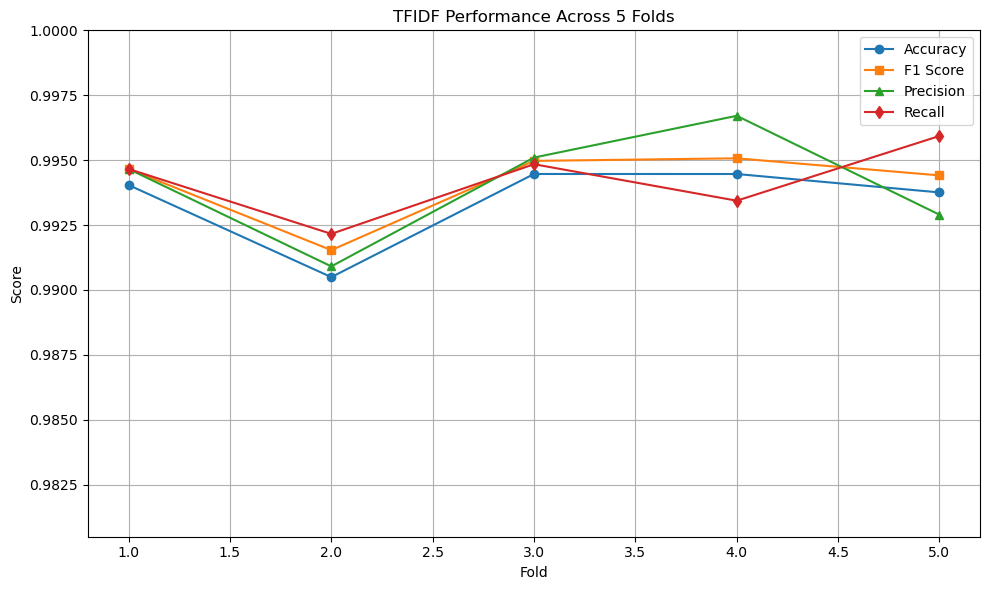


Final Test Accuracy using tfidf:0.9938712972420838
              precision    recall  f1-score   support

           0   0.992499  0.993645  0.993072      1731
           1   0.994961  0.994050  0.994505      2185

    accuracy                       0.993871      3916
   macro avg   0.993730  0.993848  0.993789      3916
weighted avg   0.993873  0.993871  0.993872      3916



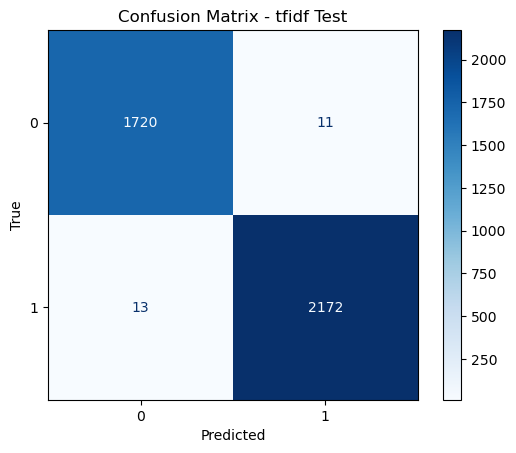

In [9]:
model_tfidf,tfidf_vec = run_and_test("tfidf")

Fold 1: Accuracy=0.9933, F1=0.9940, Precision=0.9902, Recall=0.9980
Fold 2: Accuracy=0.9898, F1=0.9909, Precision=0.9855, Recall=0.9965
Fold 3: Accuracy=0.9933, F1=0.9940, Precision=0.9895, Recall=0.9985
Fold 4: Accuracy=0.9928, F1=0.9936, Precision=0.9902, Recall=0.9970
Fold 5: Accuracy=0.9912, F1=0.9922, Precision=0.9864, Recall=0.9980

BOW Avg Accuracy over 5 folds: 0.9921
BOW Avg F1-score: 0.9929
BOW Avg Precision: 0.9884
BOW Avg Recall: 0.9976


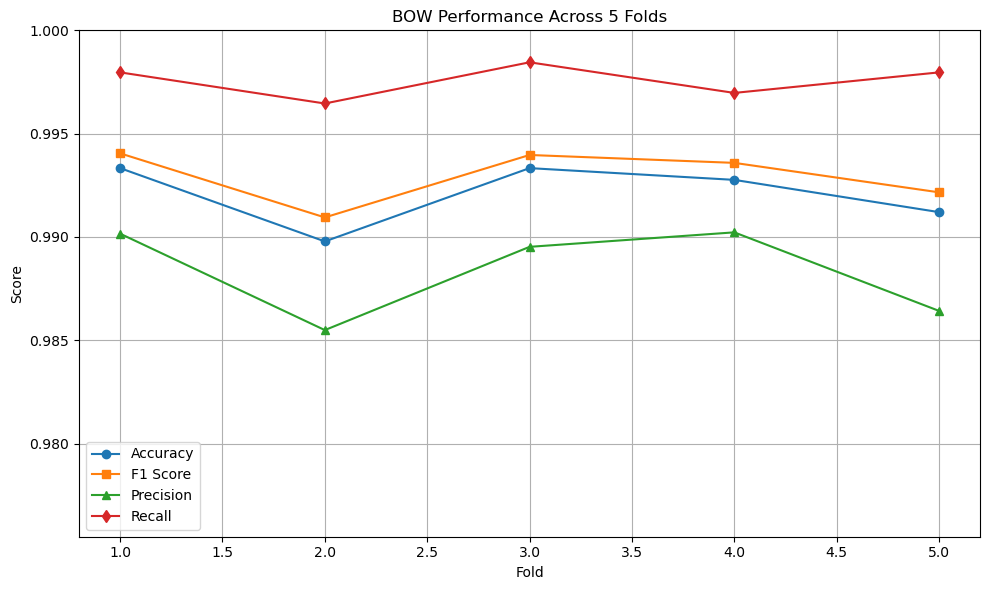


Final Test Accuracy using bow:0.9918283963227783
              precision    recall  f1-score   support

           0   0.996493  0.984980  0.990703      1731
           1   0.988209  0.997254  0.992711      2185

    accuracy                       0.991828      3916
   macro avg   0.992351  0.991117  0.991707      3916
weighted avg   0.991871  0.991828  0.991823      3916



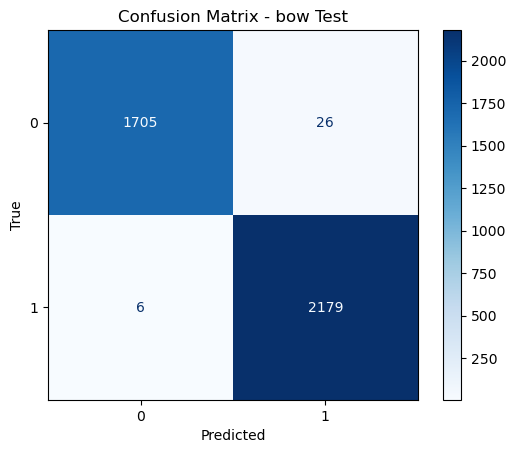

In [10]:
model_bow,bow_vec = run_and_test("bow")

In [11]:
import joblib
joblib.dump(model_bow,"model_bow_lr.pkl")
joblib.dump(bow_vec,"bow_vec_lr.pkl")


['bow_vec_lr.pkl']

In [12]:
import joblib
joblib.dump(model_tfidf,"model_tfidf_lr.pkl")
joblib.dump(tfidf_vec,"tfidf_vectorizer_lr.pkl")


['tfidf_vectorizer_lr.pkl']